In [1]:
import warnings
from typing import List, Tuple, Type

import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


/var/folders/bx/gzbw6rqj1_dg2cswsj6km8_80000gq/T/ipykernel_48177/1640127863.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def load_data() -> pd.DataFrame:
    """
    Load data to dataframe
    """
    return pd.read_excel('./data/ChemRev_Hydration_Data.xlsx', sheet_name='HydrationData',usecols = 'A:R')

In [3]:
def data_preparation(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['RH'] >= 95.0]
    not_include = ['Cast','LV','RH_r','Pret_Time', 'RH']
    df = df.query('Study != "Alberti" and EW == 1100')
    df = df.query('LV_id in (0, 1)')
    df['LV_id'] = df['LV_id'].astype(int)
    df = df.drop(not_include, axis=1)
    df = df[df['Thickness'].notnull()]
    return df

In [4]:
def unstack_liquid_vapor_datasets(df: pd.DataFrame, fixed_columns: List[str]) -> pd.DataFrame:
    """
    Input DataFrame:
        ...fixed_columns..., LV_id, lambda

    Output DataFrame:
        ...fixed_columns..., lambda_lv_0, lambda_lv_1

    example for fixed_columns: [EW, Thickness, PT, Cast_id, Drying_Temp, Equilibrium_hr, Temperature, RH]
    """
    agg_columns = fixed_columns + ['LV_id']
    df_agg = df[agg_columns + ['lambda']].groupby(agg_columns).mean()
    df_agg = df_agg.drop_duplicates().reset_index()
    df_wide = df_agg.set_index(fixed_columns + ['LV_id']).unstack('LV_id')
    df_wide.columns = [f'{col[0]}_lv_{col[1]}' for col in df_wide.columns]
    df_wide = df_wide.reset_index()
    return df_wide

In [5]:
def data_set_cases(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create 2 sub data sets for the purpose of investigating which works better for downstream analysis.

    Data set 1: Remove Equilibrium_hr column entirely

    Data set 2: Keep Equilibrium_hr column, but eliminate all null entry records
    """
    df_1_columns = df.columns.values.tolist()
    df_1_columns.remove('Equilibrium_hr')
    df_1 = df[df_1_columns]
    df_2 = df[df['Equilibrium_hr'].notnull()]

    return df_1, df_2

In [6]:
def knn_impute(df: pd.DataFrame, exclude_columns: List, **params) -> pd.DataFrame:
    """
    Perform KNN imputation while excluding specified columns.
    """

    qualifying_parameters = ['n_neighbors', 'weights']
    knn_params = {k: params[k] for k in qualifying_parameters if k in params}

    knn_imputer = KNNImputer(**knn_params)
    df_copy = df.copy()
    # fit_columns = [_column for _column in df_copy.columns.values if _column not in exclude_columns]
    df_copy = df_copy.drop(exclude_columns, axis=1)

    df_copy = pd.DataFrame(knn_imputer.fit_transform(df_copy), columns=df_copy.columns)
    for _column in exclude_columns:
        df_copy[_column] = df[_column]

    return df_copy

In [7]:
def impute_lambda_lv(df: pd.DataFrame, **params) -> pd.DataFrame:
    """
    Perform the specific imputation of lambda_lv_0 and lambda_lv_1
    """
    df_imputed = knn_impute(df=df, exclude_columns=['lambda_lv_0'], **params)
    df_imputed = knn_impute(df=df_imputed, exclude_columns=['lambda_lv_1'], **params)
    return df_imputed

In [8]:
def compute_performance_metric_delta_lambda(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input:
    DataFrame with columns
        ...predictors..., RH, lambda_lv_1, lambda_lv_0

    Output:
        DataFrame with columns
        ...predictors..., delta_lambda
    """
    if 'RH' in df.columns.values:
        df = df[df['RH'] >= 95.0]
        df = df.drop('RH', axis=1)
    df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
    df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)
    return df

In [9]:
def create_train_test_set(df: pd.DataFrame, **params) -> pd.DataFrame:

    fixed_columns = [_c for _c in ['Thickness', 'PT', 'Cast_id', 'Drying_Temp', 'Equilibrium_hr', 'Temperature'] if _c in df.columns.values.tolist()]
    df_unstacked = unstack_liquid_vapor_datasets(df=df, fixed_columns=fixed_columns)

    df_test = df_unstacked.dropna()
    df_train = df_unstacked.copy()
    df_train['is_train'] = df_train.apply(lambda row: np.isnan(row['lambda_lv_0']) or np.isnan(row['lambda_lv_1']), axis=1)
    df_train = df_train[df_train['is_train']]
    df_train = df_train.drop('is_train', axis=1)
    df_train = impute_lambda_lv(df_train, **params)

    df_train = compute_performance_metric_delta_lambda(df_train)
    df_test = compute_performance_metric_delta_lambda(df_test)


    return df_train, df_test

In [10]:
def compute_performance_metric_delta_lambda(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input:
    DataFrame with columns
        ...predictors..., RH, lambda_lv_1, lambda_lv_0

    Output:
        DataFrame with columns
        ...predictors..., delta_lambda
    """
    if 'RH' in df.columns.values:
        df = df[df['RH'] >= 95.0]
        df.drop('RH', axis=1)
    df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
    df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)
    return df

In [11]:
def train_evaluate_model(df_train: pd.DataFrame, df_test: pd.DataFrame, regressor_class: Type[BaseEstimator], y_column: str = 'delta_lambda', plot: bool = True):

    y_train = df_train[y_column].values
    y_test = df_test[y_column].values
    x_columns = [_x for _x in df_train.columns.values if _x != y_column]
    x_train = df_train[x_columns].values
    x_test = df_test[x_columns].values

    rg = regressor_class()
    rg.fit(x_train, y_train)
    y_hat = rg.predict(x_test)
    score = rg.score(x_test, y_test)

    if plot:
        plt.scatter(y_test, y_hat)
        plt.title(f"Predicted vs. actual : {y_column} -- score: {score}")

    return score

0.729420186398868

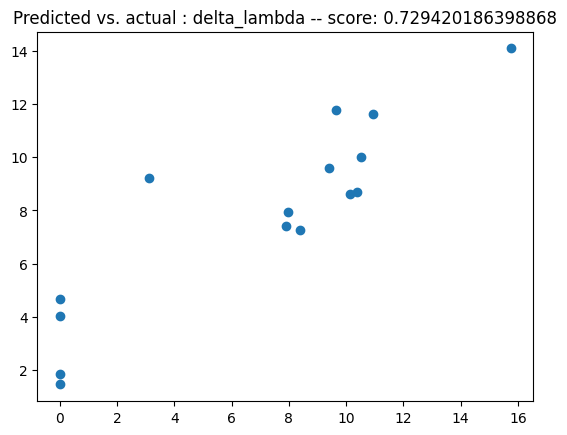

In [12]:
df = load_data()
df = data_preparation(df)
df_1, df_2 = data_set_cases(df)
df_train_1, df_test_1 = create_train_test_set(df_1)
train_evaluate_model(df_train=df_train_1, df_test=df_test_1, regressor_class=RandomForestRegressor, y_column='delta_lambda')

Text(0, 0.5, 'score')

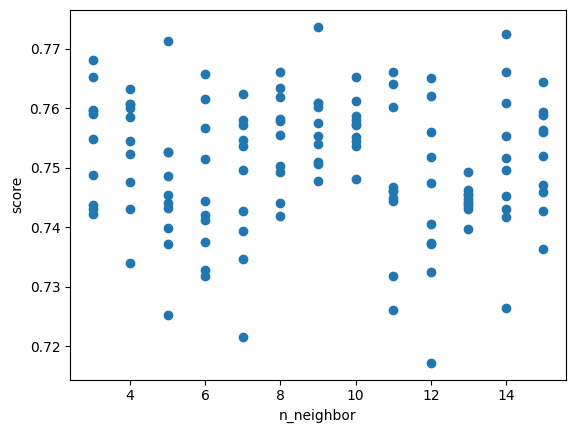

In [13]:
n_neighbors = []
scores = []

for _ in range(10):
    for n_neighbor in range(3, 16):
        df = load_data()
        df = data_preparation(df)
        df_1, _ = data_set_cases(df)
        df_train_1, df_test_1 = create_train_test_set(df_1, n_neighbor=n_neighbor)
        score = train_evaluate_model(df_train=df_train_1, df_test=df_test_1, regressor_class=RandomForestRegressor, y_column='delta_lambda', plot=False)
        n_neighbors.append(n_neighbor)
        scores.append(score)

plt.scatter(n_neighbors, scores)
plt.xlabel("n_neighbor")
plt.ylabel("score")